# ENCODE bigWig analysis questions

Do your best to answer all parts of each question. You are encouraged to collaborate, but should turn in your own answers. 

Please limit each answer to a maximum of one markdown cell, one code cell and one plot. 

Put helper functions into a separate script (e.g. `hwutils.py`) so the notebook can be focused on plotting. Also see the [workshop on Clean Code](https://drive.google.com/file/d/1TraVwRkbkCbHq-s_-NS69ZEbRNwH8XNh/view) from Dan Larremore (https://larremorelab.github.io/slides/) for good coding tips to use in this assignment.


## Written by: Cecilia Liu
## Group member: Cathy Ma

In [1]:
# useful libraries to import

import pandas as pd
import numpy as np

import  sklearn.decomposition

import matplotlib.pyplot as plt
from matplotlib.ticker import EngFormatter
bp_formatter = EngFormatter('b') 
# nice way to format ticks as human-readable: ax.xaxis.set_major_formatter(bp_formatter)

from statsmodels.graphics.tsaplots import plot_acf
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import MDS

from hwutils import autocorr

In [2]:
# load dataFrame of bigWigs from ENCODE (encodeproject.org/), binned to 10kb resolution across chromosome 10.
# note that the first three columns are chrom,start,end and the other columns are labeled by bigWig file accession.
df = pd.read_table('./data/ENCODE_GRCh38_binned_subset.tsv')

# load metadata from ENCODE for bigwig files. 
# can be queried as follows: bigwig_metadata.query("`File accession`==@ df_column_name ")
bigwig_metadata = pd.read_table('./data/ENCODE_GRCh38_bigWig_metadata.tsv',low_memory=False)
bigwig_metadata = bigwig_metadata.apply(lambda x: x.astype(str).str.strip())

- After loading the data (above), and visualize some of the profiles. Why might many signals dip on chr10 at around 40Mb?


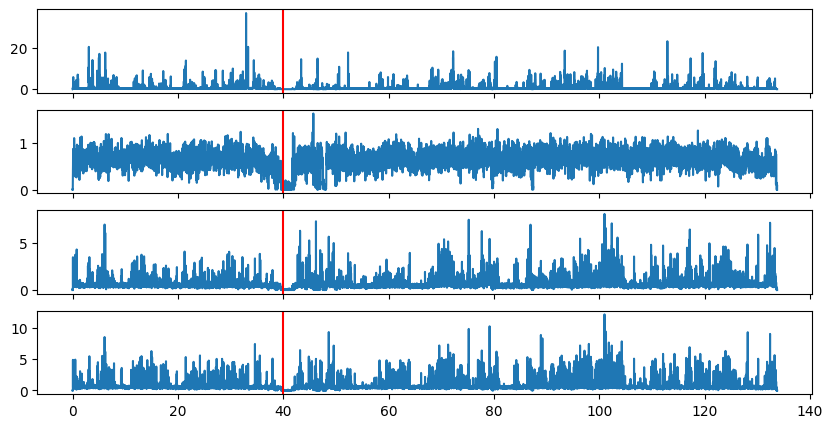

In [3]:
fig, ax = plt.subplots(4, sharex = True, figsize=(10,5))
id = ["ENCFF640PJT", "ENCFF230YBR", "ENCFF953CVO", "ENCFF418EBS" ]
x = np.arange(0 , 133.8, 0.01)

for i in range(0,4):
    ax[i].plot(x,df[id[i]])
    ax[i].axvline(40,color='r')

The reason why many signals dip at around 40mb is that 40mb is the location of centromere of chromosome 10. At centromere, the rate of protein combination like transcript factor and histone will decrease due to its compacted structure.

- Use scikit-learn to perform PCA, and make a scatterplot of PC1 vs PC2.


Text(0, 0.5, 'PC2')

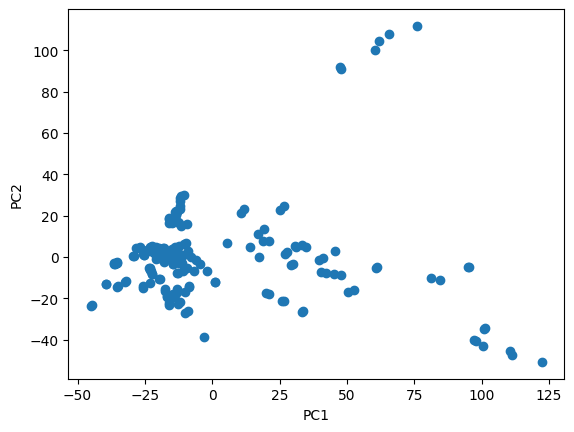

In [4]:
df_pure = df.iloc[:, 3:]
df_trans = df_pure.transpose()
pca = sklearn.decomposition.PCA(n_components = 2)
pca.fit(df_trans)
x_pca = pca.transform(df_trans)
plt.scatter(x_pca[:,0],x_pca[:,1])
plt.xlabel("PC1")
plt.ylabel("PC2")

- Try to use the experiment metadata to understand and remove outliers. Try labeling or coloring points by various metadata columns. Were any columns in the metadata useful for outlier removal? Note that `sklearn.preprocessing.LabelEncoder()` can be useful for transforming text strings to categories, and `plt.text` can be used to overlay labels with points.

/tmp/SLURM_17308447/ipykernel_15803/947876656.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.text(x_pca[idx,0], x_pca[idx, 1], str(features_values[idx]), fontsize=12)
/tmp/SLURM_17308447/ipykernel_15803/947876656.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.text(x_pca[idx,0], x_pca[idx, 1], str(features_values[idx]), fontsize=12)
/tmp/SLURM_17308447/ipykernel_15803/947876656.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

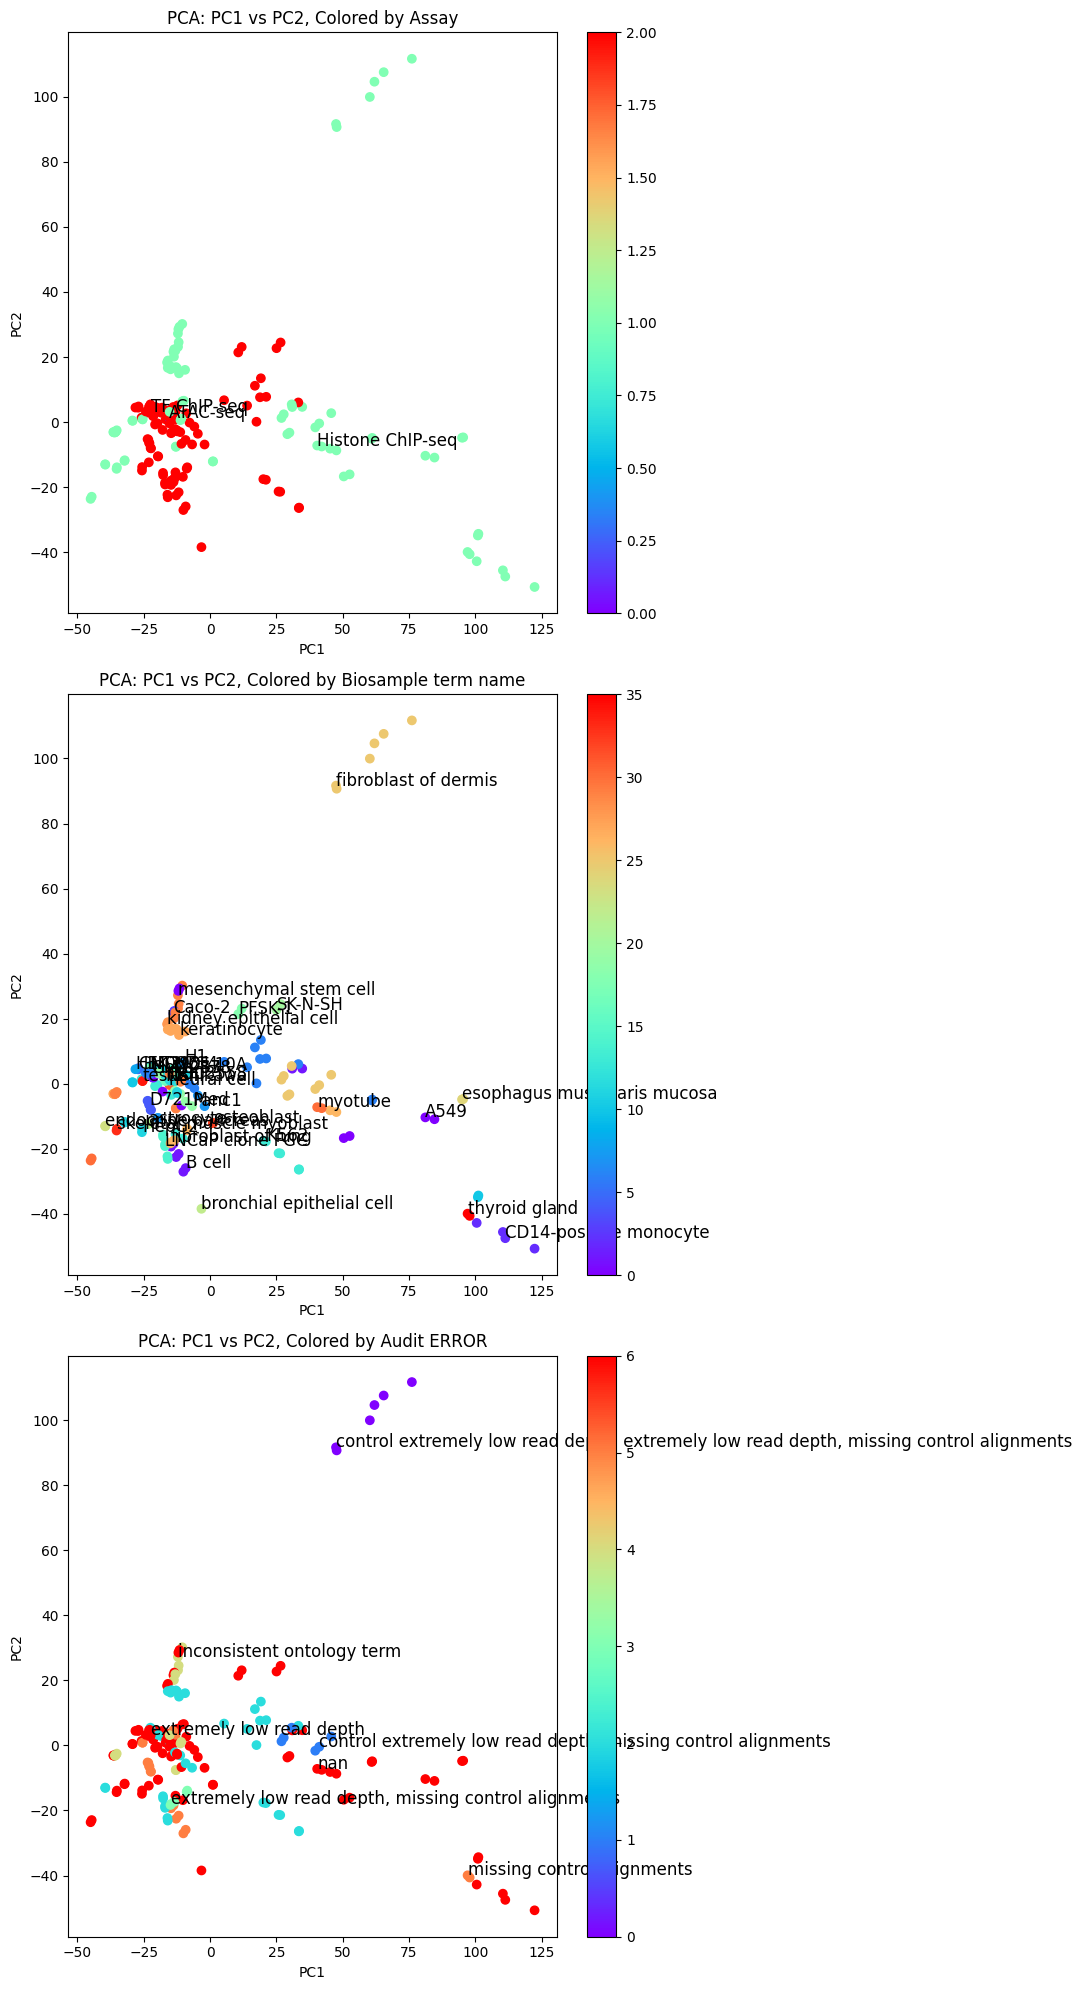

In [5]:
bigwig_metadata_indexed = bigwig_metadata.set_index('File accession').reindex(df_trans.index)
labels = ['Assay', 'Biosample term name', 'Audit ERROR']
label_encoder = sklearn.preprocessing.LabelEncoder()
fig, axes = plt.subplots(len(labels), 1, figsize=(10,20))
ax = np.ravel(axes)
for i, feature in enumerate(labels):
    features_values = bigwig_metadata_indexed[feature]
    features_values_encoded = label_encoder.fit_transform(features_values)
    ax = axes[i]
    sc = ax.scatter(x_pca[:,0],x_pca[:,1], c = features_values_encoded, cmap='rainbow')
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.set_title(f"PCA: PC1 vs PC2, Colored by {feature}")
    plt.colorbar(sc, ax=ax)
    for idx in (np.unique(features_values_encoded, return_index=True))[1]:
        ax.text(x_pca[idx,0], x_pca[idx, 1], str(features_values[idx]), fontsize=12)
plt.tight_layout()
plt.show()

Based on the plot, we can use Audit ERROR to remove outliers like the purple data points on the upper left corner.

- Which Assays or Experiment Targets show broad vs narrow patterns? Is this consistent across cell types? Does this relate to the patterns seen in PCA? One way to investigate the characteristic scale is by computing the autocorrelation.


In [6]:
auto_corr = pd.DataFrame(autocorr(df_trans))

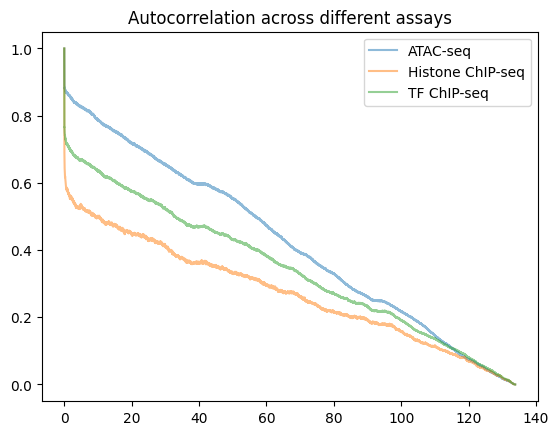

In [7]:
bigwig_reset = bigwig_metadata_indexed.reset_index()
auto_corr['Assay']=bigwig_reset['Assay']
mean_assay = auto_corr.groupby('Assay').mean()
ind = mean_assay.index.tolist()
for i in range(3):
    plt.plot(x, mean_assay.iloc[i,:],alpha = 0.5, label = ind[i])
    
plt.title('Autocorrelation across different assays')
plt.legend()
plt.show()



In the plot for autocorrelation, ATAC-seq has a rather slow decreasing rate compared to histone and transcription factors meaning that it's pattern last longer. Therefore, the ATAC has a relatively broad patterns while histone and transcription factors have relatively narrow patterns. We can't really observe ATAC-seq data on the PCA file but for histone and TF, we find that histone is more scatterly distributed while TF is more clustered.

- Which "Experiment Targets" (e.g. histone marks or transcription factors) for which cell types are nearby in this PC1 vs PC2 space? Do any of these proximities have plausible biological interpretations? For example, are any polycomb-related factors in proximity? Illustrate this in a plot.


/tmp/SLURM_17308447/ipykernel_15803/2854930548.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  marker_total.append(marker[bigwig_metadata_indexed['Assay'][i]])
/tmp/SLURM_17308447/ipykernel_15803/2854930548.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(x_pca[idx,0], x_pca[idx, 1], str(features_values[idx]), fontsize=12)


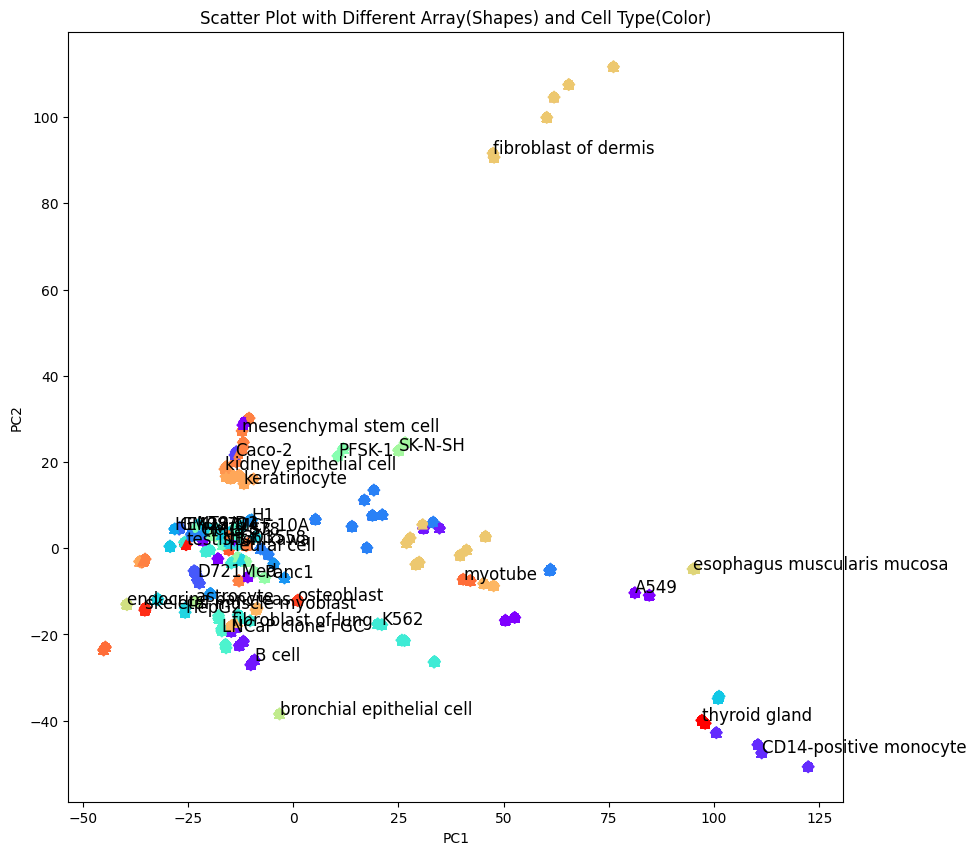

In [8]:
marker = {'TF ChIP-seq':'o', 'Histone ChIP-seq':'^', 'ATAC-seq':'D'}
marker_total=[]
for i in range(200):
    marker_total.append(marker[bigwig_metadata_indexed['Assay'][i]])

features_values = bigwig_metadata_indexed['Biosample term name']
features_values_encoded = label_encoder.fit_transform(features_values)

plt.figure(figsize=(10,10))
for i in range(200):
    sc = plt.scatter(x_pca[:,0],x_pca[:,1], c = features_values_encoded, cmap='rainbow', marker=marker_total[i])
plt.colorbar(sc, ax=ax)
for idx in (np.unique(features_values_encoded, return_index=True))[1]:
    plt.text(x_pca[idx,0], x_pca[idx, 1], str(features_values[idx]), fontsize=12)
    
# Set axis labels and a title
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Scatter Plot with Different Array(Shapes) and Cell Type(Color)')

# Display the plot
plt.show()

For histone marks, the myotube and fibroblast are nearby. Both of them are tissue cells so that there will be more histones involved in their activities. Also, the polycomb protein will repress transcription and methylate the histones. 

- How much does preprocessing matter? Try normalizing the variance per track and see if you arrive at similar or distinct conclusions. Try removing the region on chr10 mentioned above. Note that `sklearn.preprocessing.StandardScaler` could be useful for preprocessing. 


In [ ]:
df_pure = df.iloc[:, 3:]
df_pure = df_pure.drop(range(3800,4300), axis='index')

scaler = StandardScaler()
df_norm = scaler.fit_transform(df_pure)
df_trans = df_norm.transpose()

pca = sklearn.decomposition.PCA(n_components = 2)
pca.fit(df_trans)
x_pca = pca.transform(df_trans)

plt.scatter(x_pca[:,0],x_pca[:,1])
plt.xlabel("PC1")
plt.ylabel("PC2")

labels = ['Assay', 'Biosample term name']
label_encoder = sklearn.preprocessing.LabelEncoder()
fig, axes = plt.subplots(len(labels), 1, figsize=(10,15))
ax = np.ravel(axes)
for i, feature in enumerate(labels):
    features_values = bigwig_metadata_indexed[feature]
    features_values_encoded = label_encoder.fit_transform(features_values)
    ax = axes[i]
    sc = ax.scatter(x_pca[:,0],x_pca[:,1], c = features_values_encoded, cmap='rainbow')
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.set_title(f"PCA: PC1 vs PC2, Colored by {feature}")
    plt.colorbar(sc, ax=ax)
    for idx in (np.unique(features_values_encoded, return_index=True))[1]:
        ax.text(x_pca[idx,0], x_pca[idx, 1], str(features_values[idx]), fontsize=12)
plt.tight_layout()
plt.show()

/tmp/SLURM_17308447/ipykernel_15803/2719031483.py:30: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.text(x_pca[idx,0], x_pca[idx, 1], str(features_values[idx]), fontsize=12)
/tmp/SLURM_17308447/ipykernel_15803/2719031483.py:30: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.text(x_pca[idx,0], x_pca[idx, 1], str(features_values[idx]), fontsize=12)


The distribution is still similar where histones have scattered distribution while the TFs have clusttered distribution. Remarkbly, the identity of the points on the upper group changes from histones to TF.

- How many PCs are needed to explain 90% of the variance in the data? Illustrate this with a scree plot (https://en.wikipedia.org/wiki/Scree_plot). 


In [ ]:
pca = sklearn.decomposition.PCA(n_components = 100)
pca.fit(df_trans)
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)
# Find the number of components to explain at least 90% of the variance
n_components_90 = np.argmax(cumulative_variance >= 0.90) + 1
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='-')
plt.axvline(n_components_90,color='r')
plt.title("Scree Plot")
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance Ratio")
plt.grid()
plt.show()

Based on the scree plot, we need 47 PCs to explain 90% of the variance in the data.

- How different is the dimensionality reduction into two dimensions for PCA from that obtained using MDS (multi-dimensional scaling)? What methods could be used to determine the similarity? Illustrate with a plot.


In [ ]:
mds = MDS(n_components=2)
X_mds = mds.fit_transform(df_trans)

feature = 'Assay'
features_values = bigwig_metadata_indexed[feature]
features_values_encoded = label_encoder.fit_transform(features_values)
sc = plt.scatter(X_mds[:,0],X_mds[:,1], c = features_values_encoded, cmap='rainbow')
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title(f"MDS: PC1 vs PC2, Colored by {feature}")
plt.colorbar(sc, ax=ax)
for idx in (np.unique(features_values_encoded, return_index=True))[1]:
    plt.text(X_mds[idx,0], X_mds[idx, 1], str(features_values[idx]), fontsize=12)
plt.show()

For MDS, one thing that is different from PCA is that the plot changes for every run. However, they share similarities such that their distributions for assay is very similar. The histone is always scattered on the outside while TF is grouped near the center of the plot.

- Would non-negative matrix factorization (https://en.wikipedia.org/wiki/Non-negative_matrix_factorization) be a useful method to use for this dataset? Why or why not?  (No plots needed for this question).


Yes, non-negative matrix factorization can conduct dimension reduction across the genome and analyze the peak pattern. The requirement to be eligible for non-negative matrix factorization is to have non-negative values which our Chip-seq data follows. 